In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs682/assignments/assignment3/'
FOLDERNAME = 'Object_localization_based_on_textual_description'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


Mounted at /content/drive


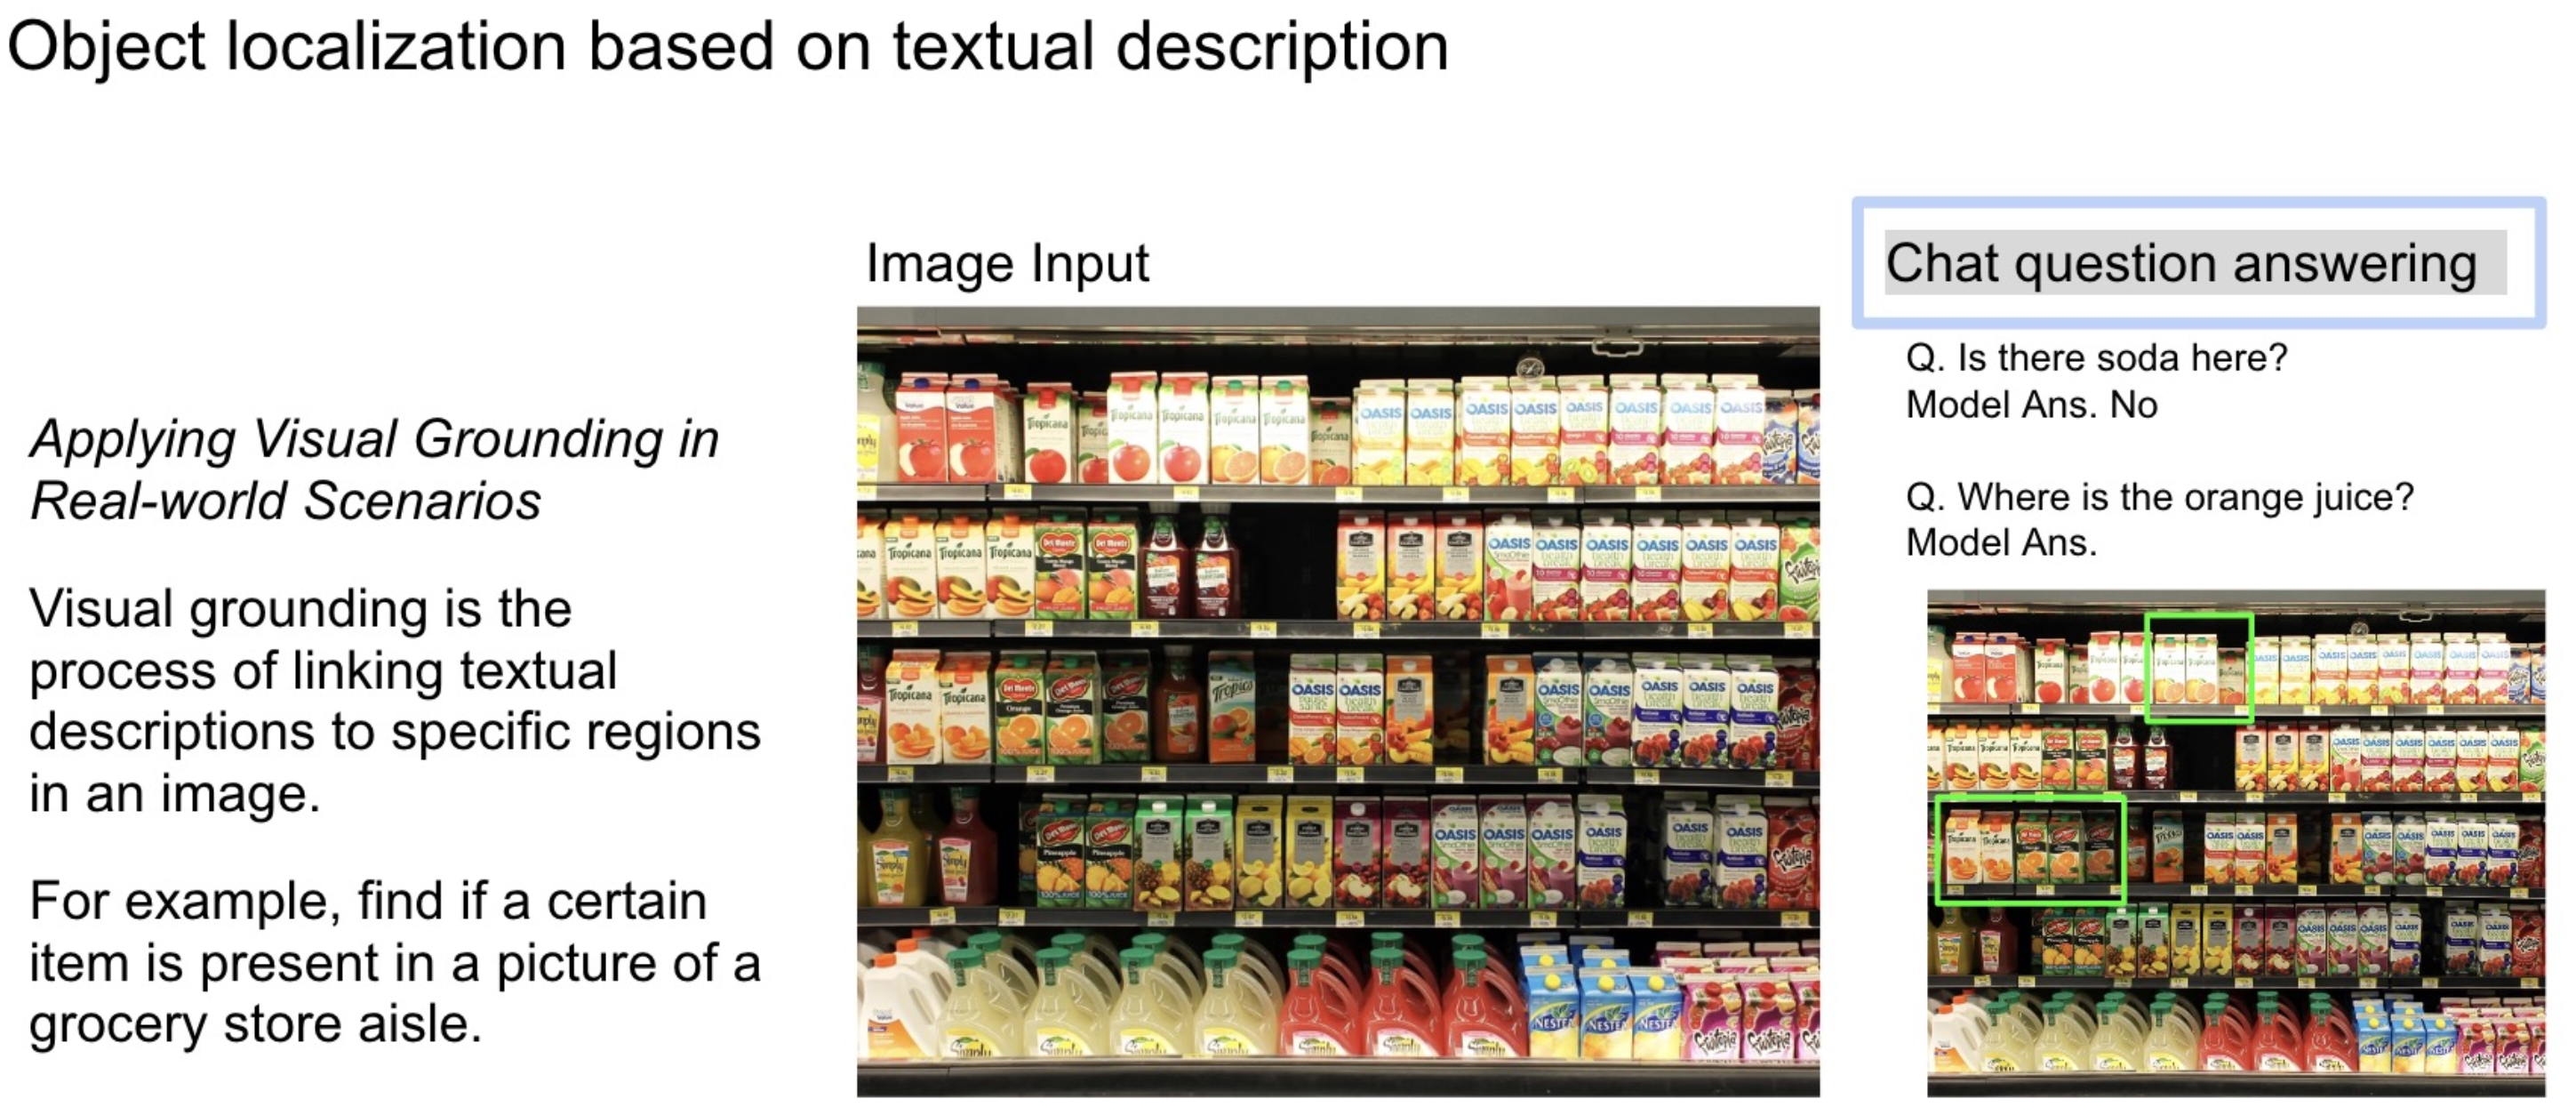

# Object Localization


## Load the Pre-trained YOLOv3 Model and Process the Image
**Reference:**
1. https://github.com/iArunava/YOLOv3-Object-Detection-with-OpenCV/blob/master/yolo.py

2. https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/

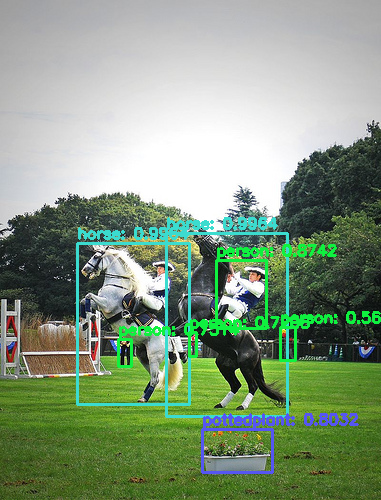

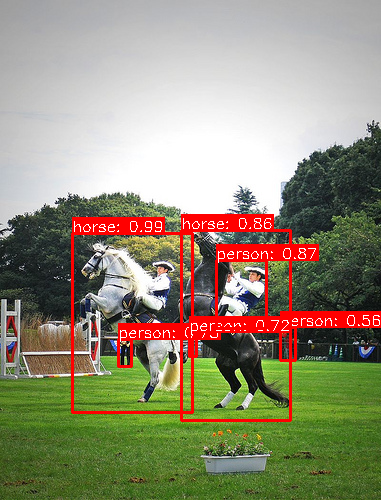

In [ ]:
import numpy as np
import cv2 as cv
import os
import time
from google.colab.patches import cv2_imshow
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from collections import defaultdict

# Configuration settings
model_path = '/content/drive/My Drive/Object_localization_based_on_textual_description/yolov3-coco/'
weights_path = model_path + 'yolov3.weights'
config_path = model_path + 'yolov3.cfg'
labels_path = model_path + 'coco-labels'
image_path = '/content/drive/My Drive/Object_localization_based_on_textual_description/input_image/person.jpg'
confidence_threshold = 0.5
nms_threshold = 0.3
show_time = False
directory_path = '/content/drive/My Drive/Object_localization_based_on_textual_description/input_image'

def display_image(img):
    plt.figure(figsize=(12, 9))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def show_image(img):
    cv2_imshow(img)

# Function to draw labels and boxes on the image
def draw_labels_and_boxes(img, boxes, confidences, classids, idxs, colors, labels):
    if len(idxs) > 0:
        for i in idxs.flatten():
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]
            color = [int(c) for c in colors[classids[i]]]
            cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(labels[classids[i]], confidences[i])
            cv.putText(img, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return img

# Function to generate boxes, confidences, and classids from YOLO model output
def generate_boxes_confidences_classids(outs, height, width, tconf):
    boxes = []
    confidences = []
    classids = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classid = np.argmax(scores)
            confidence = scores[classid]
            if confidence > tconf:
                box = detection[0:4] * np.array([width, height, width, height])
                centerX, centerY, bwidth, bheight = box.astype('int')
                x = int(centerX - (bwidth / 2))
                y = int(centerY - (bheight / 2))
                boxes.append([x, y, int(bwidth), int(bheight)])
                confidences.append(float(confidence))
                classids.append(classid)
    return boxes, confidences, classids

def infer_image(net, layer_names, height, width, img, colors, labels, confidence, threshold, show_time, infer=True):
    if infer:
        blob = cv.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        start = time.time()
        outs = net.forward(layer_names)
        end = time.time()
        if show_time:
            print("[INFO] YOLOv3 took {:.6f} seconds".format(end - start))
        boxes, confidences, classids = generate_boxes_confidences_classids(outs, height, width, confidence)
        idxs = cv.dnn.NMSBoxes(boxes, confidences, confidence, threshold)

    if boxes is None or confidences is None or idxs is None or classids is None:
        raise ValueError('[ERROR] Required variables are set to None before drawing boxes on images.')
    img = draw_labels_and_boxes(img, boxes, confidences, classids, idxs, colors, labels)
    return img, boxes, confidences, classids

# Function to display image with bounding boxes that combines overlapping boxes for the same label
def display_image_with_boxes(image_path, detections, labels_of_interest):
    # Load the image
    img = cv.imread(image_path)

    # Check if image is loaded
    if img is None:
        raise ValueError("Image cannot be loaded!\nPlease check the path provided!")

    # Convert labels_of_interest to lower case for case-insensitive comparison
    labels_of_interest = [label.lower() for label in labels_of_interest]

    # Group detections by label
    grouped_detections = defaultdict(list)
    for detection in detections:
        if detection['label'].lower() in labels_of_interest:
            grouped_detections[detection['label'].lower()].append(detection)

    # Perform NMS and combine overlapping boxes for each label
    for label, label_detections in grouped_detections.items():
        boxes = np.array([d['box'] for d in label_detections])
        confidences = np.array([d['confidence'] for d in label_detections])
        nms_boxes, nms_scores = nms(boxes, confidences, 0.3)  # Overlap threshold can be adjusted

        # Draw combined bounding boxes for each group
        for box, score in zip(nms_boxes, nms_scores):
            # Draw the bounding box
            cv.rectangle(img, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 0, 255), 2)

            # Prepare the label text with the label and the confidence
            label_text = "{}: {:.2f}".format(label, score)

            # Calculate width and height of the label text box
            (text_width, text_height), _ = cv.getTextSize(label_text, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)

            # Draw the label text background
            cv.rectangle(img, (box[0], box[1] - text_height - 4), (box[0] + text_width, box[1]), (0, 0, 255), -1)
            # Put the label text on the image
            cv.putText(img, label_text, (box[0], box[1] - 2), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Display the image with bounding boxes
    cv2_imshow(img)

# Helper function to perform Non-Maximum Suppression
def nms(boxes, scores, overlapThresh):
    # If no boxes, return an empty list
    if len(boxes) == 0:
        return [], []

    # Initialize the list of picked indexes
    pick = []

    # Grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]

    # Compute the area of the bounding boxes and sort the bounding boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # Keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # Grab the last index in the indexes list and add the index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest (x, y) coordinates for the start of the bounding box and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have overlap greater than the provided threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Return only the bounding boxes that were picked using the integer data type
    return boxes[pick].astype("int"), scores[pick]

# Main execution
if __name__ == '__main__':
    # Get the labels
    labels = open(labels_path).read().strip().split('\n')

    # Initializing colors to represent each label uniquely
    colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

    # Load the weights and configuration to form the pretrained YOLOv3 model
    net = cv.dnn.readNetFromDarknet(config_path, weights_path)

    # Get the output layer names of the model
    layer_names = net.getLayerNames()
    unconnected_out_layers = net.getUnconnectedOutLayers()
    layer_names = [layer_names[i - 1] for i in unconnected_out_layers.flatten()]

    # Process a single image
    try:
        img = cv.imread(image_path)
        height, width = img.shape[:2]
        img, _, _, _ = infer_image(net, layer_names, height, width, img, colors, labels, confidence_threshold, nms_threshold, show_time)
        show_image(img)
    except Exception as e:
        raise ValueError("Image cannot be loaded!\nPlease check the path provided! Error: {}".format(e))

    if directory_path:
      image_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.lower().endswith(('.jpg', '.png'))]

      for image_path in image_paths:
          try:
              img = cv.imread(image_path)
              if img is None:
                  raise ValueError("Image not loaded")
              height, width = img.shape[:2]
              img, boxes, confidences, classids = infer_image(net, layer_names, height, width, img, colors, labels, confidence_threshold, nms_threshold, show_time)

              # Create detections in the required format
              detections = [{'box': box, 'confidence': conf, 'classID': cid, 'label': labels[cid]} for box, conf, cid in zip(boxes, confidences, classids)]

              labels_of_interest = ['horse', 'person']  # Add more labels as needed
              display_image_with_boxes(image_path, detections, labels_of_interest)

          except Exception as e:
              print(f"Error processing {image_path}: {e}")

Please run **`!python3 'path-to-yolo.py' --directory-path='path-to-your-input-image'`**.

In [ ]:
# !python3 '/content/drive/My Drive/Object_localization_based_on_textual_description/yolo.py' --directory-path='/content/drive/My Drive/Object_localization_based_on_textual_description/input_image'


# Q&A System

In [ ]:
# If you haven't installed spaCy or the English language model,
# uncomment the following two lines of code and run this cell.

# !pip install spacy
!python3 -m spacy download en_core_web_lg
import numpy as np
import spacy
import os
import csv
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

## Define NLP Functions

In [ ]:
import numpy as np
import spacy

# Load spaCy model with word vectors
nlp = spacy.load("en_core_web_lg")

# List of labels
labels = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# Function to find the most similar label for a word
def find_most_similar_label(word, labels):
    word_vector = nlp(word).vector
    word_norm = np.linalg.norm(word_vector)
    most_similar_label = None
    highest_similarity = 0.5  # Adjust threshold as needed

    if word_norm == 0:  # Check if word vector is zero
        return most_similar_label

    for label in labels:
        label_vector = nlp(label).vector
        label_norm = np.linalg.norm(label_vector)

        if label_norm == 0:  # Check if label vector is zero
            continue

        similarity = np.dot(word_vector, label_vector) / (word_norm * label_norm)

        if similarity > highest_similarity:
            most_similar_label = label
            highest_similarity = similarity

    return most_similar_label


# Function to process text and filter nouns
def process_text(text, labels):
    doc = nlp(text)
    label_map = {}  # Map to store the most similar label for each noun

    for token in doc:
        if token.pos_ == "NOUN":
            word = token.text.lower()
            most_similar_label = find_most_similar_label(word, labels)
            if most_similar_label:
                label_map[most_similar_label] = word

    return list(label_map.keys())

# Function to check if text starts with 'Where' or 'where'
def starts_with_where(text, labels):
    if text.strip().lower().startswith('where'):
        return True, process_text(text, labels)
    else:
        return False, process_text(text, labels)

# # Get user input
# user_input_text = input("Enter your text: ")

# # Check the text and process
# starts_with_where_flag, detected_nouns = starts_with_where(user_input_text, labels)
# print("Starts with 'Where':", starts_with_where_flag)
# print("Detected nouns similar to labels:", detected_nouns)


## Integrate Q&A with NLP

In [ ]:
def process_question(question, detections, image_path):
    starts_with_where_flag = question.strip().lower().startswith('where')
    detected_nouns = process_text(question, labels)
    target_detected = any(detection['label'].lower() in detected_nouns for detection in detections)

    if starts_with_where_flag and target_detected:
        img = cv.imread(image_path)
        if img is None:
            raise ValueError("Image not loaded")
        height, width = img.shape[:2]
        _, boxes, confidences, classids = infer_image(net, layer_names, height, width, img, colors, labels, confidence_threshold, nms_threshold, show_time)

        # Create detections in the required format
        detections = [{'box': box, 'confidence': conf, 'classID': cid, 'label': labels[cid]} for box, conf, cid in zip(boxes, confidences, classids)]

        labels_of_interest = []
        for noun in detected_nouns:
          if noun in labels:
            labels_of_interest.append(noun)
        display_image_with_boxes(image_path, detections, labels_of_interest)
    else:
        print("Yes" if target_detected else "No")

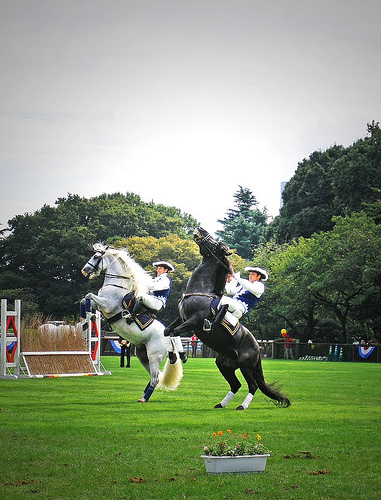

In [ ]:
image_path ='/content/drive/My Drive/Object_localization_based_on_textual_description/input_image/person.jpg'
img = cv.imread(image_path)
cv2_imshow(img)

Enter your text: where is the horse


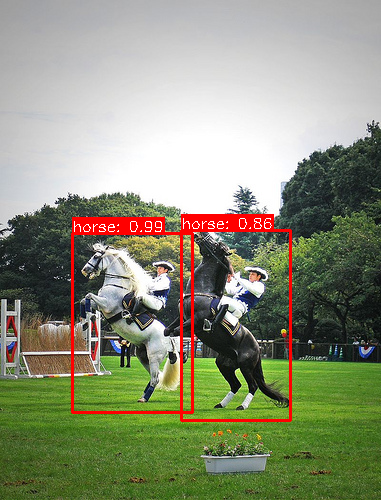

In [ ]:
image_path ='/content/drive/My Drive/Object_localization_based_on_textual_description/input_image/person.jpg'
# Get user input and process the question
user_input_text = input("Enter your text: ")
process_question(user_input_text, detections, image_path)

Test with accuracy

In [ ]:
#!pip install pycocotools

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
import skimage.io as io
import cv2
import numpy as np
import os
import time


In [ ]:
coco_annotation_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
!wget {coco_annotation_url}
!unzip annotations_trainval2017.zip
coco = COCO('annotations/instances_val2017.json')


In [ ]:
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]

# Print category names
print(category_names)
print(len(category_names))

In [ ]:
num_image = 1000
imgIds = coco.getImgIds()[:num_image]  # Adjust the number of images as needed
score = 0
for imgId in imgIds:
    img_info = coco.loadImgs(imgId)[0]
    annId = coco.getAnnIds(imgId)
    anns = coco.loadAnns(annId)

    category_ids = [ann['category_id'] for ann in anns]
    #print(category_ids)
    category_names = [coco.loadCats(id)[0]['name'] for id in category_ids]
    true_category_names = sorted(list(set(category_names)))
    #print(true_category_names)

    image_url = img_info['coco_url']

    # Load image from URL
    img = io.imread(image_url)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR format
    height, width = img.shape[:2]
    # Process image with YOLOv3 using perform_inference
    processed_img, boxes, confidences, classids = infer_image(net, layer_names, height, width, img, colors, labels, confidence_threshold, nms_threshold, show_time)
    #print(classids)
    predict_names = [labels[id] for id in classids]
    predict_names = sorted(list(set(predict_names)))
    #print(predict_names)
    #print('-------')

    temp_score = 0
    for name in predict_names:
      if name in true_category_names:
        temp_score += 1
    if len(true_category_names) > 0:
      score += temp_score/len(true_category_names)

    # Display the image with detections
    # plt.figure(figsize=(10,10))
    # plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    # plt.show()

score /= num_image
print(score)

0.7850175574425572
